Importing Libraries

In [7]:
import pandas as pd
import mlflow
import json
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (accuracy_score, recall_score,
                             f1_score, precision_score)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Tracking Model
mlflow.set_tracking_uri('sqlite:///../tmp/mlflow/mlflow.db')
mlflow.set_experiment('Weather Forcast')

2023/12/16 22:44:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/12/16 22:44:06 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/godwin/Documents/Workflow/Weather-Forecast/notebooks/mlruns/1', creation_time=1702763047528, experiment_id='1', last_update_time=1702763047528, lifecycle_stage='active', name='Weather Forcast', tags={}>

In [147]:
def read_data(path):

    data = pd.read_csv(path)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    categorical_col = data.dtypes[data.dtypes == 'object'].index.tolist()

    for col in categorical_col:
        data[col] = data[col].str.lower().str.replace(' ', '_')
    return data

In [173]:
def data_preparation(data):


    #data['date'] = pd.to_datetime(data['date'])
    data['raintomorrow'] = (data['raintomorrow'] == 'yes').astype('int')
    
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=0)
    train_y, test_y = train_df.pop('raintomorrow'), test_df.pop('raintomorrow')
    outputs = (train_df, test_df, train_y, test_y)
  
    return outputs

In [150]:
data = read_data('../raw_data/weatherAUS.csv')

In [151]:
numerical_col = data.select_dtypes(exclude=['object']).columns.tolist()
categorical_col = data.select_dtypes(include=['object']).columns.tolist()

<Axes: >

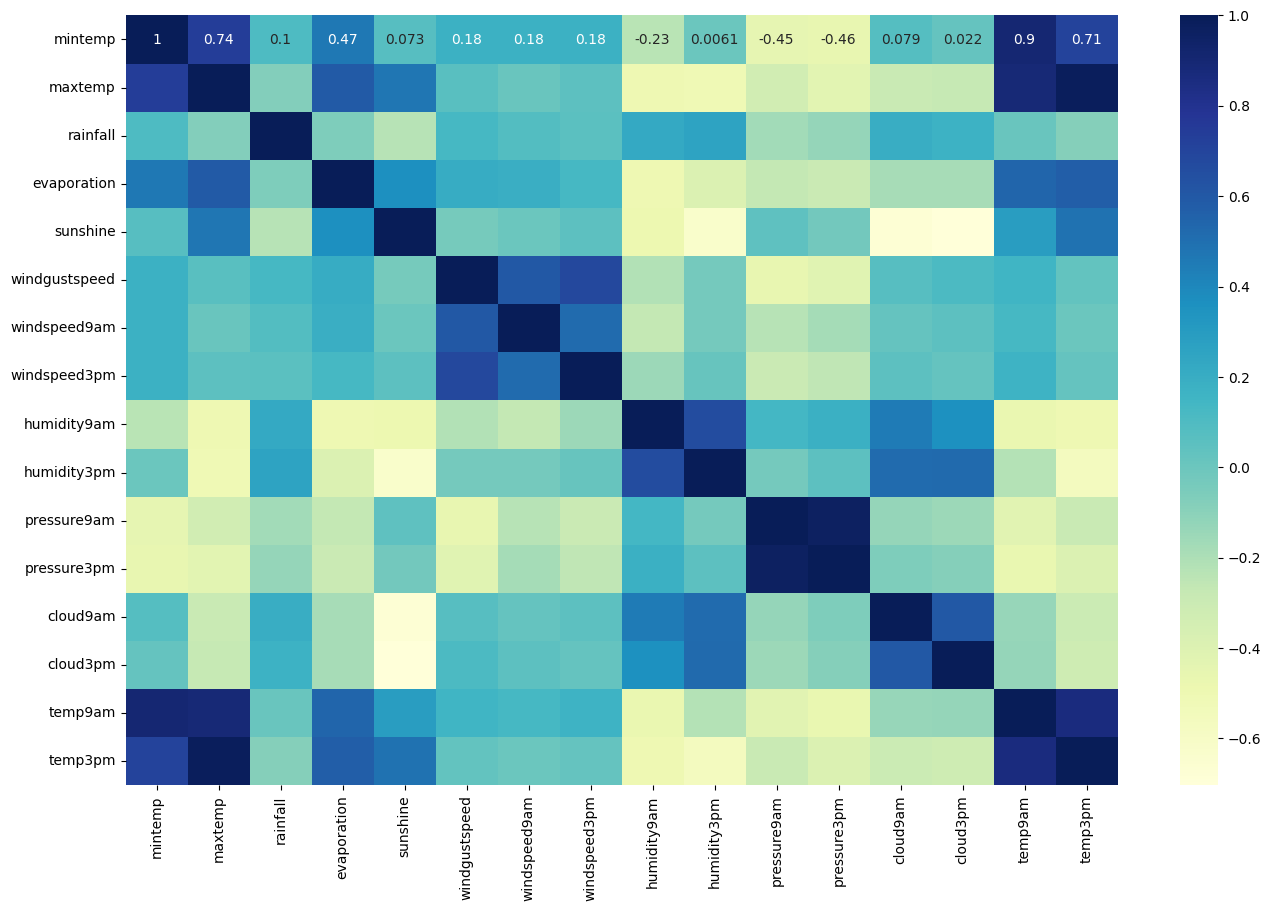

In [152]:
plt.figure(figsize =  (16,10))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

<Axes: >

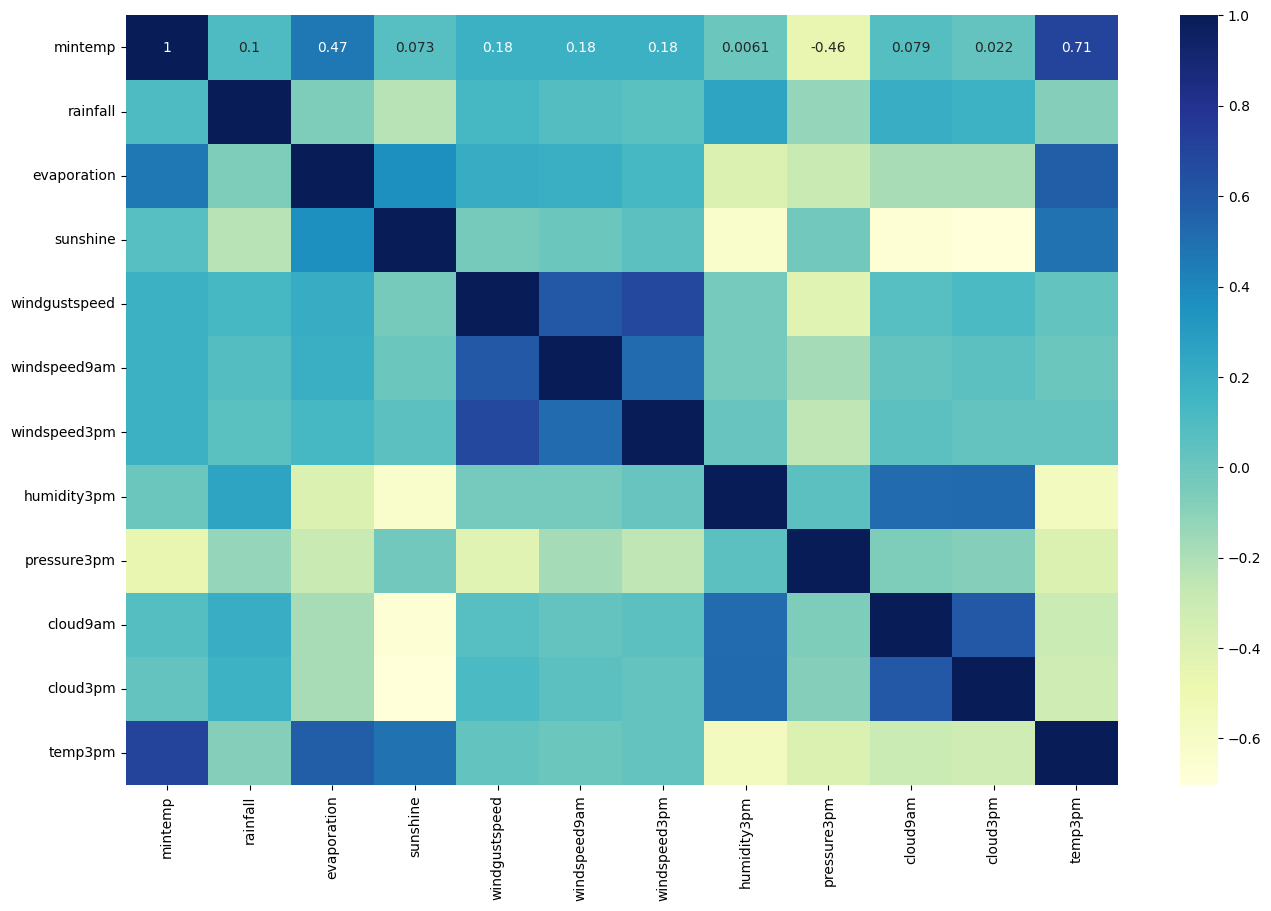

In [153]:
plt.figure(figsize =  (16,10))

drop_columns = ['humidity9am', 'pressure9am', 'temp9am', 'maxtemp']
new = data.drop(drop_columns, axis = 1)
sns.heatmap(new.corr(), cmap="YlGnBu", annot=True)

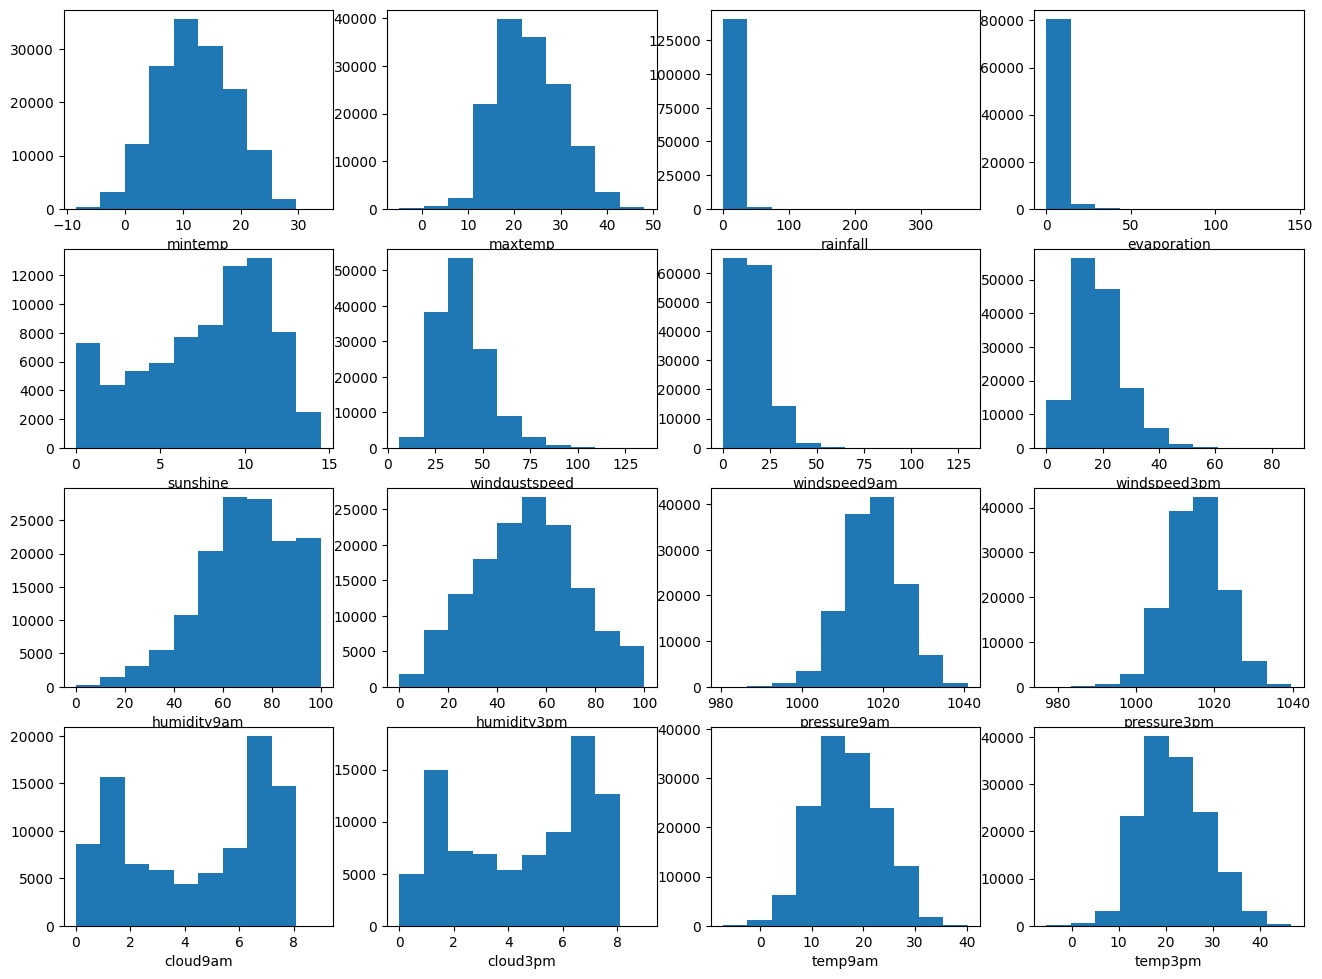

In [154]:
plt.figure(figsize=(16,15))
no_row = int((len(numerical_col)/4) + 1)

for i,col in enumerate(numerical_col):
    plt.subplot(no_row, 4, i+1)
    plt.hist(data[col])
    plt.xlabel(col)

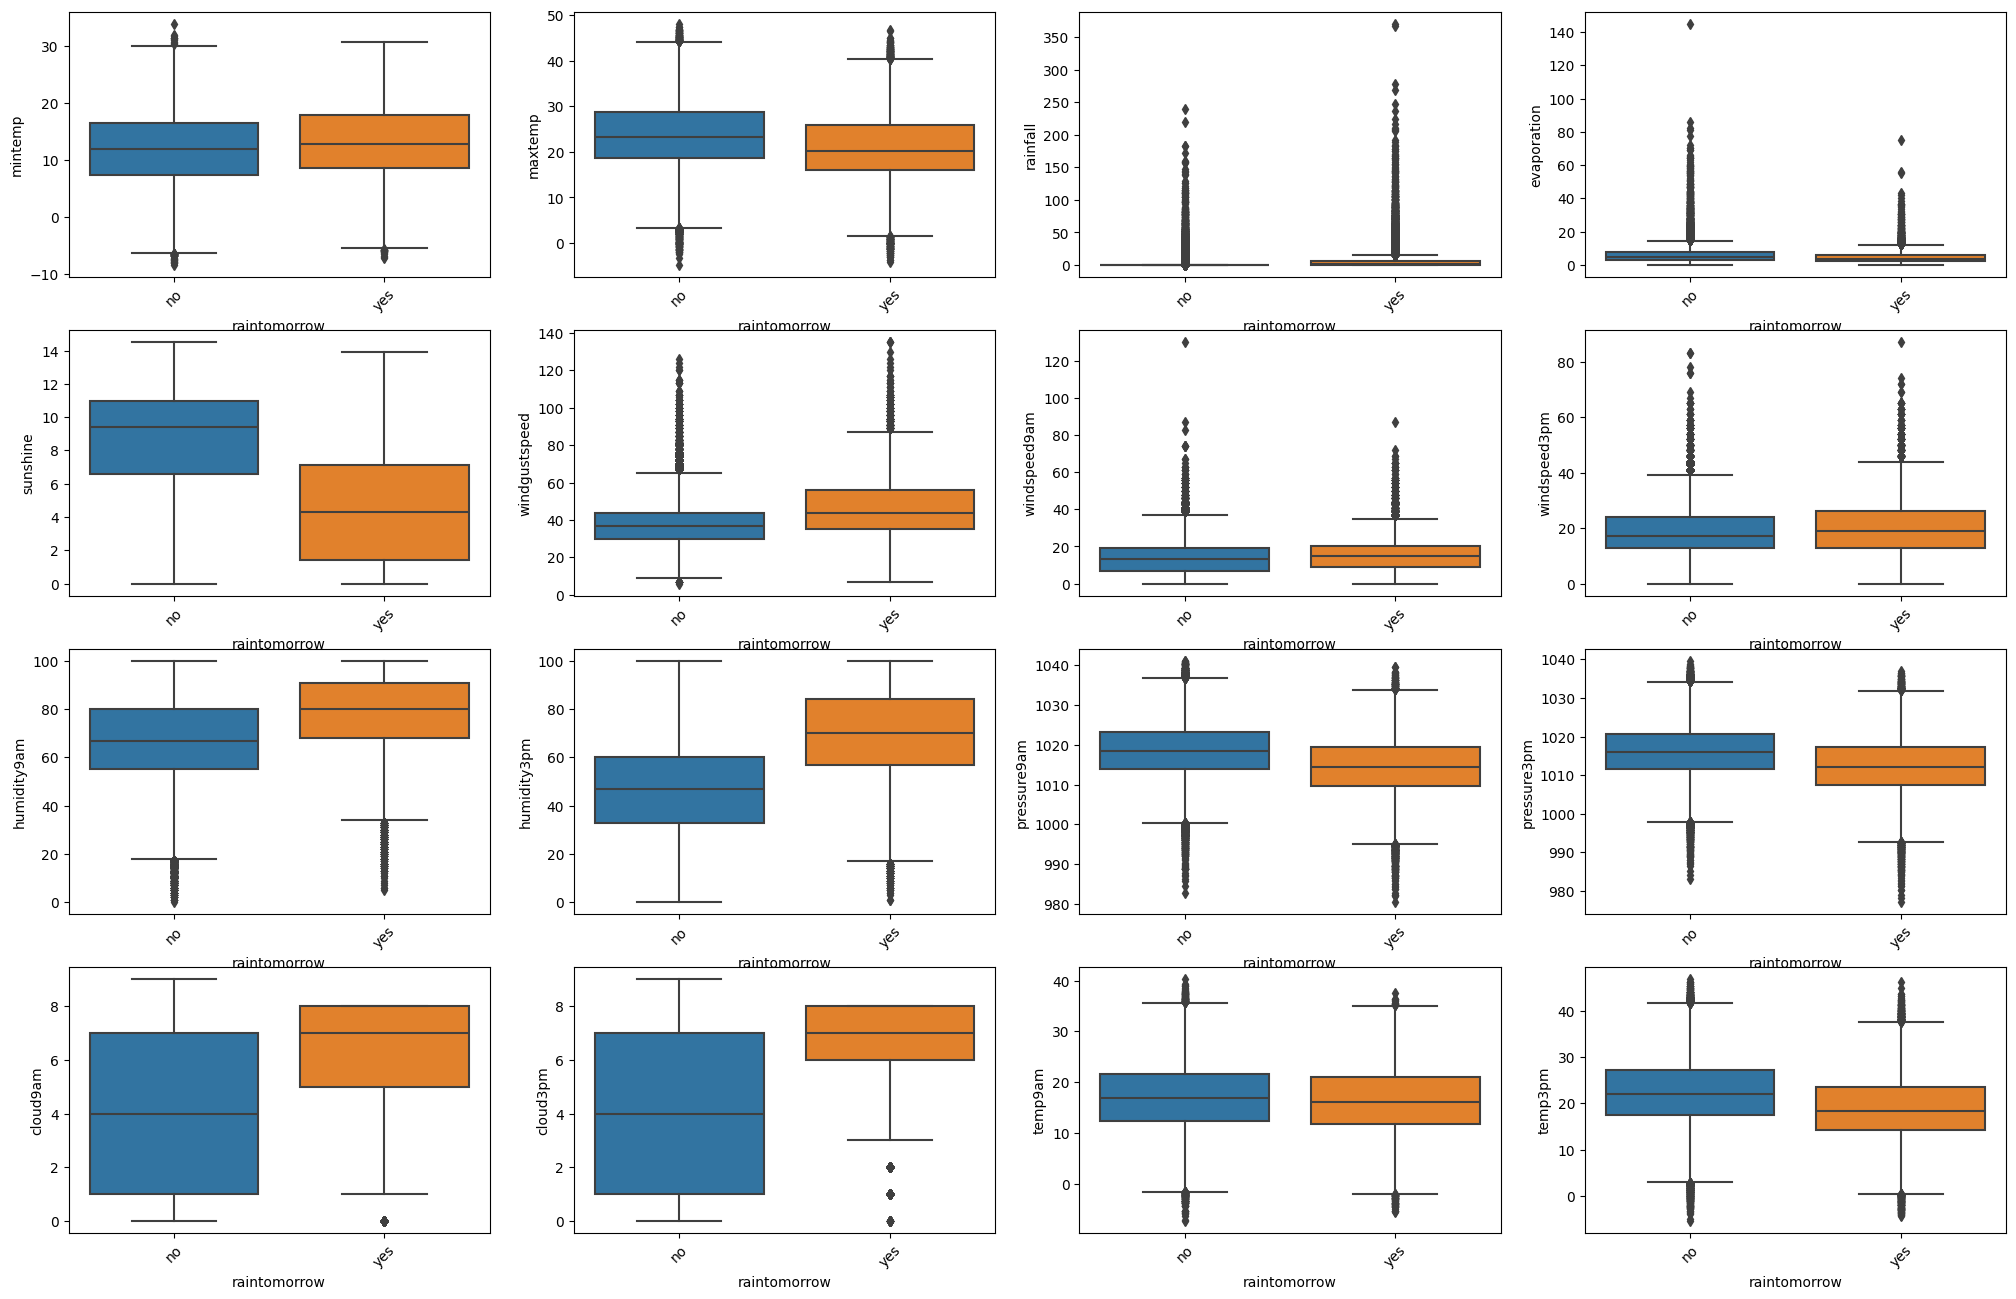

In [155]:
plt.figure(figsize=(25,20))
no_rows = int(len(numerical_col)/4) + 1

for i,col in enumerate(numerical_col):
    plt.subplot(no_rows,4, i+1)
    sns.boxplot(x = 'raintomorrow', y = col, data = data)
    plt.ylabel(col)
    plt.xticks(rotation = 45)

In [156]:
percentiles_to_check = [0.25, 0.50, 0.90, 1.0]

# Use the percentile method on the desired column
percentiles_values = data['rainfall'].quantile(q = [p for p in percentiles_to_check])

# Print the results
for percentile, value in zip(percentiles_to_check, percentiles_values):
    print(f"{percentile}th percentile: {value}")

0.25th percentile: 0.0
0.5th percentile: 0.0
0.9th percentile: 6.2
1.0th percentile: 371.0


In [157]:
def not_normal_prep(data, column_name):

    percentile_value = data[column_name].quantile(q = 0.85)
    column_data = (data[column_name] <= percentile_value)
    column_mean = column_data.mean()
    data[column_name] = data[column_name].fillna(column_mean)
    data = data[data[column_name] <=  percentile_value]
    return data


In [158]:
def data_encoding(train_data, val_data):

    
    feature_names = {'Feature_names': train_data.columns.to_list()}
    
    cat_col = train_data.dtypes[train_data.dtypes == 'object'].index.tolist()
    num_col = train_data.dtypes[train_data.dtypes == 'float64'].index.tolist()

    vectorizer = DictVectorizer(sparse = False)
    vectorizer.fit(train_data[cat_col + num_col].to_dict(orient = 'records'))

    X_train = vectorizer.transform(train_data[cat_col + num_col].to_dict(orient = 'records'))
    X_val = vectorizer.transform(val_data[cat_col + num_col].to_dict(orient = 'records'))
    outputs = (feature_names, X_train, X_val, vectorizer)

    return outputs

In [164]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [170]:
def impute_and_scale_data(df_features: pd.DataFrame) -> pd.DataFrame:
   
    # Impute data with mean strategy
    numerical_col = df_features.select_dtypes(exclude=['object']).columns.tolist()
    imputer = SimpleImputer(strategy="mean")
    df_features[numerical_col] = imputer.fit_transform(df_features[numerical_col].values)

    # Scale and fit with zero mean and unit variance
    scaler = StandardScaler()
    df_features[numerical_col] = scaler.fit_transform(df_features[numerical_col])

    return scaler, df_features #pd.DataFrame(X_preprocessed, columns=df_features.columns),

drop_columns = ['humidity9am', 'pressure9am', 'temp9am', 'maxtemp', 'date']
new = data.drop(drop_columns, axis = 1)
new = new[new['rainfall'] <= 30]
new = not_normal_prep(new, 'rainfall')
new = not_normal_prep(new, 'evaporation')
scaler, new = impute_and_scale_data(new)

In [174]:
train_data, val_data,y_train, y_val = data_preparation(new)
feature_names, X_train, X_val, vectorizer = data_encoding(train_data, val_data)

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_val, label = y_val)

In [175]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [176]:
def objective(params):
    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")
        mlflow.set_tag('scaler', 'StandardScaler')
        mlflow.set_tag('feature_names', feature_names['Feature_names'])
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dtest, 'validation')],
            early_stopping_rounds=200
            )
        prediction0 = booster.predict(dtest)
        prediction = (prediction0 >= 0.5).astype('int')
        
        f1 = f1_score(y_val, prediction)
        output = {"acc": accuracy_score(y_val, prediction), 
                  "f1_score": f1_score(y_val, prediction), 
                  "precision": precision_score(y_val, prediction),
                   "recall": recall_score(y_val, prediction)}
        mlflow.log_metrics(output)

    return {'loss': -f1, 'status': STATUS_OK}

In [177]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-logloss:0.43661                        
[1]	validation-logloss:0.41798                        
[2]	validation-logloss:0.40285                        
[3]	validation-logloss:0.39070                        
[4]	validation-logloss:0.38068                        
[5]	validation-logloss:0.37179                        
[6]	validation-logloss:0.36460                        
[7]	validation-logloss:0.35886                        
[8]	validation-logloss:0.35389                        
[9]	validation-logloss:0.35011                        
[10]	validation-logloss:0.34671                       
[11]	validation-logloss:0.34348                       
[12]	validation-logloss:0.34102                       
[13]	validation-logloss:0.33884                       
[14]	validation-logloss:0.33682                       
[15]	validation-logloss:0.33493                       
[16]	validation-logloss:0.33383                       
[17]	validation-logloss:0.33293                       
[18]	valid

In [181]:
best_result['seed'] = 42
best_result['objective'] = 'binary:logistic'

with open('../parameters.json', 'w') as json_file:
    json.dump(best_result, json_file, indent=2)

In [84]:
def fearure_engineering(df):
    
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
   
    df['temp_diff'] = df['maxtemp'] - df['mintemp']
    df['pressure_diff'] = df['pressure3pm'] - df['pressure9am']
    df['temp_time_diff'] = df['temp3pm'] - df['temp9am']
    df['cloud_diff'] = df['cloud3pm'] - df['cloud9am']
    df['wind_speed_diff'] = df['windspeed3pm'] - df['windspeed9am']
    df['humidity_diff'] = df['humidity3pm'] - df['humidity9am']
    corr_col = ['mintemp', 'pressure9am', 'temp9am', 'temp3pm', 'humidity9am', 'windspeed3pm']
    df = df.drop(corr_col, axis = 1)
    return df

data = fearure_engineering(data)
print(data.shape)
data.head()

(145460, 25)


,date,location,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,raintoday,raintomorrow,month,day,temp_diff,pressure_diff,temp_time_diff,cloud_diff,wind_speed_diff,humidity_diff
0,2008-12-01,albury,22.9,0.6,6.534638,7.649576,w,44.0,w,wnw,...,no,no,12,1,9.5,-0.6,4.9,-3.381443,4.0,-49.0
1,2008-12-02,albury,25.1,0.0,6.534638,7.649576,wnw,44.0,nnw,wsw,...,no,no,12,2,17.7,-2.8,7.1,-3.131443,18.0,-19.0
2,2008-12-03,albury,25.7,0.0,6.534638,7.649576,wsw,46.0,w,wsw,...,no,no,12,3,12.8,1.1,2.2,-5.500000,7.0,-8.0
3,2008-12-04,albury,28.0,0.0,6.534638,7.649576,ne,24.0,se,e,...,no,no,12,4,18.8,-4.8,8.4,-2.250000,-2.0,-29.0
4,2008-12-05,albury,32.3,1.0,6.534638,7.649576,w,41.0,ene,nw,...,no,no,12,5,14.8,-4.8,11.9,1.000000,13.0,-49.0
